In [1]:
!pip install statsmodels==0.12.2
!pip install import-ipynb
!pip install tflearn
!pip install hyperopt

     |████████████████████████████████| 9.5 MB 20.5 MB/s 
     |████████████████████████████████| 231 kB 81.7 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 107 kB 23.6 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127300 sha256=9285519f28617dee513efffa48615f329e89223f21b105b1eda0bec05a8ab43a
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 965 kB 28.2 MB/s 
     |████████████████████████████████| 1.6 MB 73.1 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.datasets import make_sparse_spd_matrix

from scipy.stats import random_correlation
import scipy.optimize as optimize
import scipy.interpolate as sci
import time
import tqdm
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta, Adam
import import_ipynb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, SparkTrials
from hyperopt import rand
import plotly.express as px
import sys

# Data

In [ ]:
class Data:
    def __init__(self, seed, size, data_len,n_past,train_size):
        self.seed = seed
        self.size = size
        self.data_len = data_len
        self.cov = None
        self.pi_matrix = None
        self.price_series = []
        self.expected_returns = []
        self.actual_returns = []
        self.n_past = n_past
        self.train_size = train_size

    def set_random_cov(self):    
        np.random.seed(self.seed)
        eigen = np.random.dirichlet(np.ones(self.size), size=1)[0]*self.size
        x = random_correlation.rvs(eigen, random_state=self.seed)
        D = np.diag(np.random.uniform(low=0.008, high=0.02, size=(1,self.size))[0])
        # print(D)
        self.cov = D @ x @ D.T

    def get_cov(self):
        return self.cov

    def set_random_pi_matrix(self):
        np.random.seed(self.seed)
        pi_diag = np.diag(np.random.uniform(low=-0.3, high=0.3, size=(1,self.size))[0])
        start_mat = np.random.rand(self.size, self.size)
        #Brug eigen decom i stedet
        s, v, d = np.linalg.svd(start_mat, full_matrices=False)
        pi_lin_comb = s @ d
        self.pi_matrix = pi_lin_comb @ pi_diag @ pi_lin_comb.T

    def get_pi_matrix(self):
        return self.pi_matrix

    def generate_data(self):
        self.set_random_cov()
        self.set_random_pi_matrix()
        self.price_series = np.empty([0, self.size])
        self.actual_returns = np.empty([0, self.size])
        self.expected_returns = np.empty([0, self.size])
        prices = np.random.uniform(low=100, high=200, size=(1,self.size))[0]
        self.price_series = np.vstack([self.price_series,prices])
        returns = np.random.uniform(low=-0.005, high=0.02, size=(1,self.size))[0]
        self.actual_returns = np.vstack([self.actual_returns, returns])
        # c = np.random.uniform(low=-0.0001, high=0.002, size=(1,self.size))
        c = np.array([0.0001 for _ in range(self.size)])
        # c = np.array([0.001, 0.0011, 0.0009, 0.00095, 0.00098, 0.00099, 0.00075, 0.00065, 0.00055, 0.00025])
        # print(f'{self.seed}: {c}')

        for i in range(self.data_len):
            noise = np.random.multivariate_normal(np.zeros_like(returns), self.cov)
            self.expected_returns = np.vstack([self.expected_returns, self.pi_matrix @ returns + c])
            returns = self.expected_returns[-1] + noise
            self.actual_returns = np.vstack([self.actual_returns, returns])
            prices = prices + prices * returns
            self.price_series = np.vstack([self.price_series, prices])

        return self.price_series, self.cov, self.expected_returns, self.actual_returns

    def split_series(self):
        """
        Desc: 

        Args:

        Returns:
        
        """

        #data_len = 1000 --> price shape = 1000
        #past_end = 150
        #window_start = 850

        X, y = list(), list()
        for window_start in range(self.price_series.shape[0]):
            past_end = window_start + self.n_past
            future_end = past_end + 1
            if future_end > self.price_series.shape[0]:
                break
            # slicing the past and future parts of the window
            past, future = self.price_series[window_start:past_end, :], self.actual_returns[past_end, :]
            X.append(past)
            y.append(future)
        self.X,self.y = np.array(X),np.array(y)

    def get_train_test_data(self):
        self.split_series()
        window = round(self.data_len*self.train_size)
        self.X_train,self.X_test = self.X[:window,:], self.X[window:,:]
        self.y_train,self.y_test = self.y[:window,:], self.y[window:,:]
        self.X_train = self.X_train.reshape((self.X_train.shape[0], self.X_train.shape[1],10))
        self.X_test = self.X_test.reshape((self.X_test.shape[0], self.X_test.shape[1],10))
        return self.X_train, self.X_test, self.y_train, self.y_test

    def plot_data(self):
        plt.figure(figsize=(15, 6))
        for i in range(self.price_series.shape[1]):
            plt.plot(self.price_series[:,i],label=f'Stock {i+1}')
        plt.legend(loc='upper left', fontsize=8)
    
    def plot_dataex(self):
        fig = px.line(self.price_series, x='year', y='price')
        fig.show()
    

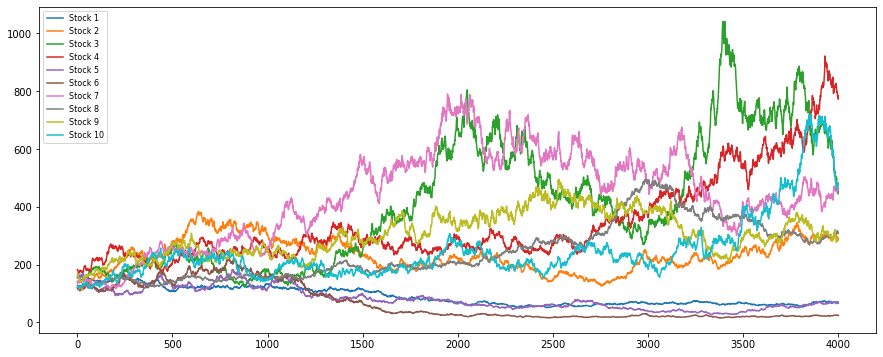

In [ ]:
data = Data(seed=32, size=10, data_len=4000, n_past=10, train_size=0.8)
price_series, cov, expected_returns, actual_returns = data.generate_data()
# price_series = tf.convert_to_tensor(price_series, dtype=tf.float32)
# actual_returns = tf.convert_to_tensor(actual_returns,dtype=tf.float32)
train_series,test_series = price_series[:2700],price_series[2700:]
train_returns,test_returns = actual_returns[:2700],actual_returns[2700:]
plt.figure(figsize=(15, 6))
for i in range(price_series.shape[1]):
    plt.plot(price_series[:,i],label=f'Stock {i+1}')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
#plt.figure(figsize=(15, 6))
#for i in range(actual_returns.shape[1]):
#    plt.plot(actual_returns[:,i],label=f'Stock {i+1}')
#plt.legend(loc='upper left', fontsize=8)

In [ ]:
#plt.figure(figsize=(15, 6))
#for i in range(expected_returns.shape[1]):
#    plt.plot(expected_returns[:,i],label=f'Stock {i+1}')
#plt.legend(loc='upper left', fontsize=8)

# Markowitz

In [ ]:
def x_gmv(cov):
    size = cov.shape[0]
    ones = np.ones(size)
    c = ones.T @ np.linalg.inv(cov) @ ones
    return (1/c) * (np.linalg.inv(cov) @ ones)

def mu_gmv(cov, expected_return):
    A = calc_A(cov, expected_return)
    return A[0,1]/A[1,1]

def calc_A(cov,expected_return):
    size = cov.shape[0]
    A = np.vstack([expected_return.T,np.ones(size)]) @ np.linalg.inv(cov)
    temp = np.vstack([expected_return.T,np.ones(size)]).T
    return np.dot(A,temp)

def x_opt(cov,expected_return,mu):
    size = cov.shape[0]
    A = calc_A(cov,expected_return)
    temp = np.dot(np.linalg.inv(cov), np.vstack([expected_return.T,np.ones(size)]).T)
    temp = np.dot(temp, np.linalg.inv(A)) @ np.array([mu,1])
    return temp

def sigma_opt(mu,cov,expected_return):
    A = calc_A(cov,expected_return)
    return np.array([[mu],[1]]).T @ np.linalg.inv(A) @ np.array([mu,1])

def x_tan(cov, expected_return):
    size = cov.shape[0]
    ones = np.ones(size)
    Si = np.linalg.inv(cov)

    denom = expected_return.T @ Si @ ones
    return (1/denom) * Si @ expected_return

def mu_tan(cov, expected_return):
    size = cov.shape[0]
    ones = np.ones(size)
    Si = np.linalg.inv(cov)
    
    numer = expected_return.T @ Si @ expected_return
    denom = expected_return.T @ Si @ ones
    return numer/denom

def x_sharpe(cov, expected_return):
    A = calc_A(cov, expected_return)
    mu_opt = np.sqrt(A[0,0]/A[1,1])
    return x_opt(cov, expected_return, mu_opt)
    

In [ ]:
class TradingStrategy:
    def __init__(self, Data):
        self.Data = Data
        self.weights = None
        self.weight_series = []
        self.pf_return = []
        self.pf_vol = []
        self.W = []
        self.cr = None
        self.vol = None
        self.sharpe = None

    def get_weights(self):
        return self.weights

    def get_weight_series(self):
        return self.weight_series

    # def set_strategy_weights(self, iteration):
    #     pass

    def calc_A(self,expected_return):
        size = self.Data.cov.shape[0]
        A = np.vstack([expected_return.T,np.ones(self.Data.size)]) @ np.linalg.inv(self.Data.cov)
        temp = np.vstack([expected_return.T,np.ones(self.Data.size)]).T
        A = np.dot(A,temp)
        return A

    def sim_trading(self):
        """
        Desc:

        Args:

        Returns:

        """
        self.W, self.pf_return, self.pf_vol = [100], [], []
        for i in range(len(self.Data.price_series) - 1):
            self.set_strategy_weights(i)
            self.weight_series.append(self.weights)
            #Fix sharpe ved ny vol beregning
            self.pf_return.append(np.dot(self.weights, self.Data.actual_returns[i]))
            self.pf_vol.append(np.sqrt(np.dot(self.weights, np.dot(self.weights,self.Data.cov))))
            self.W.append(self.W[i] * (1 + self.pf_return[i]))
        return self.W, self.pf_return, self.pf_vol
        
    def get_trading_stats(self):
        """
        Desc:

        Args:

        Returns:

        """
        self.cr = (self.W[-1]-self.W[0])/self.W[0]
        self.vol = np.std(np.array(self.pf_return))
        self.sharpe = self.cr/self.vol
        return self.sharpe, self.cr, self.vol


class SharpeStrategy(TradingStrategy):
    """

    """
    def __init__(self, Data):
        super().__init__(Data)
        self.mu_opt_series = []
        self.a_series = []
        self.b_series = []

    def set_strategy_weights(self, iteration):
        """
        Desc:

        Args:

        Returns:
        
        """
        A = self.calc_A(self.Data.expected_returns[iteration])
        mu_opt = A[0,0]/(A[0,1]) #Sharpe
        self.mu_opt_series.append(mu_opt)
        self.a_series.append(A[0,0])
        self.b_series.append(A[0,1])
        # mu_opt = np.sqrt(A[0,0] / A[1,1])
        self.weights = x_opt(self.Data.cov, self.Data.expected_returns[iteration], mu_opt)


class TangentStrategy(TradingStrategy):
    """

    """
    def __init__(self,Data):
        super().__init__(Data)

    def set_strategy_weights(self, iteration):
        Si = np.linalg.inv(self.Data.cov)
        denom = self.Data.expected_returns[iteration].T @ Si @ np.ones(self.Data.size)
        self.weights = (1/denom) * Si @ self.Data.expected_returns[iteration]

# Reinforcement Learning

In [ ]:
def custom_loss1(y_true,y_pred):
        returns = tf.reduce_sum(y_true * y_pred)
        return -tf.math.log(1+returns)

def custom_loss2(y_true,y_pred):
    x = -tf.reduce_mean(tf.math.log(tf.reduce_sum(tf.tensordot(y_true, tf.transpose(y_pred), 1))))
    return -tf.reduce_mean(tf.math.log(tf.reduce_sum(tf.tensordot(y_true, tf.transpose(y_pred), 1))))

In [ ]:
class RL_Strategy():
    def __init__(self, Data):
        self.Data = Data
    
    def create_network(self, lr=0.01, optim = 'SGD',loss_func = 1, batch_size=32):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.Data.n_past, self.Data.size)),
            tf.keras.layers.LSTM(128, recurrent_dropout=0.2, return_sequences=True),
            tf.keras.layers.LSTM(64, recurrent_dropout=0.2, return_sequences = True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(self.Data.size, activation="softmax")
            ])

        if optim == 'SGD':
            self.optimizer = tf.keras.optimizers.SGD(lr)
        elif optim == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(lr=0.01)
            
        if loss_func == 1:
            loss = custom_loss1
        elif loss_func == 2:
            loss = custom_loss2
        
        self.model.compile(loss=loss, optimizer=self.optimizer)     
        return self.model
    


* Lag
* Noder
* Dropout
* Batch_size
* Window
* Optimizer

In [ ]:
space = {
    'LSTM_Nodes1': hp.uniformint('LSTM_Nodes1', 64, 128),
    'LSTM_Nodes2': hp.uniformint('LSTM_Nodes2', 32, 64),
    'LSTM_Nodes3': hp.uniformint('LSTM_Nodes3', 16, 32),
    'LSTM_Dropout1': hp.uniform('LSTM_Dropout1', 0.0, 0.3),
    'LSTM_Dropout2': hp.uniform('LSTM_Dropout2', 0.0, 0.3),
    'LSTM_Dropout3': hp.uniform('LSTM_Dropout3', 0.0, 0.3),
    'LSTM_Reg1': hp.uniform('LSTM_Reg1', 0.0, 0.1),
    'LSTM_Reg2': hp.uniform('LSTM_Reg2', 0.0, 0.1),
    'LSTM_Reg3': hp.uniform('LSTM_Reg3', 0.0, 0.1),
    'loss_fn': hp.choice('loss_fn', [custom_loss1]),
    'batch_size': hp.uniformint('batch_size', 16, 64),
    # 'window_size': hp.uniformint('window_size', 32, 128),
    'window_size': 150,
    'lr': hp.uniform('lr', 0.005, 0.015),
    'momentum': hp.uniform('momentum', 0.0, 1.0),
    'nesterov': hp.choice('nesterov', [True, False]),
}

In [ ]:
data = Data(seed=1, size=10, data_len=2000, n_past=150, train_size=0.8)
price_series, cov, expected_returns, actual_returns = data.generate_data()
X_train,X_test,y_train,y_test = data.get_train_test_data()

In [ ]:
policy.predict(X_test).shape

(251, 10)

In [ ]:
def training(model, space):
    print ('Params testing: ', space)
    
    model.compile(loss=space['loss_fn'],optimizer=tf.keras.optimizers.SGD(learning_rate=space['lr'],momentum=space['momentum'],nesterov=space['nesterov']))
    model.summary()

    model.fit(X_train,y_train,epochs=2,validation_data=(X_test,y_test), batch_size = space['batch_size'],verbose=0)

    rets = np.array(actual_returns[-len(y_test):])
    preds = model.predict(X_test)
    acc_ret = -(tf.reduce_prod(1 + tf.reduce_sum(rets * preds, axis=1), axis=0) - 1)
    
    sys.stdout.flush() 
    return {'loss': acc_ret, 'status': STATUS_OK, 'model': model}

In [ ]:
def LSTM_training(space, *current_best, *iteration):   
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(data.n_past, data.size)),
            tf.keras.layers.LSTM(space['LSTM_Nodes1'], recurrent_dropout=space['LSTM_Dropout1'], return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(space['LSTM_Reg1'])),
            tf.keras.layers.LSTM(space['LSTM_Nodes2'], recurrent_dropout=space['LSTM_Dropout2'], return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(space['LSTM_Reg2'])),
            tf.keras.layers.LSTM(space['LSTM_Nodes3'], recurrent_dropout=space['LSTM_Dropout3'], kernel_regularizer=tf.keras.regularizers.l2(space['LSTM_Reg3'])),
            tf.keras.layers.Dense(data.size, activation="softmax")
            ])
    fit = training(model, space)

    if fit['loss'] < current_best:
        current_best = fit['loss']
        
    
    return fit

In [ ]:
best = fmin(fn=LSTM_training,
            space=space,
            algo=tpe.suggest,
            max_evals=2,
            parallelism=1,
            trials=SparkTrials())
best_df = pd.DataFrame.from_dict(best, orient='index')
best_df.columns = ['Values']
best_df.index.name = 'Keys'
best_df.to_csv('best_model.csv',sep=';')

Params testing: 
{'LSTM_Dropout1': 0.08600084667779083, 'LSTM_Dropout2': 0.15475017415168826, 'LSTM_Dropout3': 0.029230819022067943, 'LSTM_Nodes1': 108, 'LSTM_Nodes2': 37, 'LSTM_Nodes3': 24, 'LSTM_Reg1': 0.028453300256191874, 'LSTM_Reg2': 0.09454235521020543, 'LSTM_Reg3': 0.0810987907853224, 'batch_size': 49, 'loss_fn': <function custom_loss1 at 0x7fd907deb200>, 'lr': 0.010069681864336915, 'momentum': 0.236962375430406, 'nesterov': False, 'window_size': 150}
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 150, 108)          51408     
_________________________________________________________________
lstm_22 (LSTM)               (None, 150, 37)           21608     
_________________________________________________________________
lstm_23 (LSTM)               (None, 24)                5952      
_____________________________________________________

In [ ]:
best

{'LSTM_Dropout1': 0.04818190955651976,
 'LSTM_Dropout2': 0.23327709982433412,
 'LSTM_Dropout3': 0.21324378860034393,
 'LSTM_Nodes1': 121.0,
 'LSTM_Nodes2': 39.0,
 'LSTM_Nodes3': 26.0,
 'LSTM_Reg1': 0.004318855211824258,
 'LSTM_Reg2': 0.02612281418793341,
 'LSTM_Reg3': 0.05546568606266003,
 'batch_size': 21.0,
 'loss_fn': 0,
 'lr': 0.014603320010760017,
 'momentum': 0.9614132326505254,
 'nesterov': 0}

In [ ]:
trials.best_trial['result']['loss']

-0.04956838114592155

In [ ]:
pd.read_csv('best_model.csv',sep=';')

,Keys,Values
0,LSTM_Dropout1,0.173461
1,LSTM_Dropout2,0.094862
2,LSTM_Dropout3,0.032254
3,LSTM_Nodes1,111.000000
4,LSTM_Nodes2,58.000000
5,LSTM_Nodes3,32.000000
6,LSTM_Reg1,0.045259
7,LSTM_Reg2,0.061550
8,LSTM_Reg3,0.003708
9,batch_size,35.000000


In [ ]:
loss = trials.best_trial['result']['loss']
print ('loss :', loss)
model = trials.best_trial['result']['model']
print (model)

In [ ]:
rets = actual_returns[-len(y_test):]
preds = policy.predict(X_test)
print(tf.reduce_prod(1 + tf.reduce_sum(rets * preds, axis=1), axis=0) - 1)

tf.Tensor(0.07748286252348402, shape=(), dtype=float64)
1.0774828625234836


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e2fe652-9345-434d-a8f2-b4c9fce078c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>